# 데이터 확인하기 

연관 자료 : https://monkeylearn.com/keyword-extraction/

- offerings.csv : 평가의 대상이 되는 호텔들 이름과 위치, 등급 
- reviews.csv : 리뷰 데이터셋

In [105]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
df = pd.read_csv('../dataset/240128_TripAdvisorHotelReviews/reviews.csv')
df.shape

(878561, 10)

In [74]:
#데이터의 크기가 너무 크니까 샘플링해서 사용하기 
df = df.sample(frac=0.01, random_state=42)  # random_state는 재현성을 위한 시드값
df.shape

(8786, 10)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8786 entries, 340013 to 189080
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ratings            8786 non-null   object
 1   title              8786 non-null   object
 2   text               8786 non-null   object
 3   author             8786 non-null   object
 4   date_stayed        8128 non-null   object
 5   offering_id        8786 non-null   int64 
 6   num_helpful_votes  8786 non-null   int64 
 7   date               8786 non-null   object
 8   id                 8786 non-null   int64 
 9   via_mobile         8786 non-null   bool  
dtypes: bool(1), int64(3), object(6)
memory usage: 695.0+ KB


In [76]:
#숫자형 변수는 3개 밖에 없음.
#offering_id, num_helpful_votes,id
df.describe()

offering_id  num_helpful_votes            id
count  8.786000e+03        8786.000000  8.786000e+03
mean   3.010436e+05           1.130776  8.559823e+07
std    4.358950e+05           2.355795  5.012062e+07
min    7.257200e+04           0.000000  6.101660e+05
25%    9.097300e+04           0.000000  3.331775e+07
50%    1.114160e+05           0.000000  1.098008e+08
75%    2.399070e+05           1.000000  1.280653e+08
max    3.235844e+06          47.000000  1.477599e+08

array([[<Axes: title={'center': 'offering_id'}>,
        <Axes: title={'center': 'num_helpful_votes'}>],
       [<Axes: title={'center': 'id'}>, <Axes: >]], dtype=object)

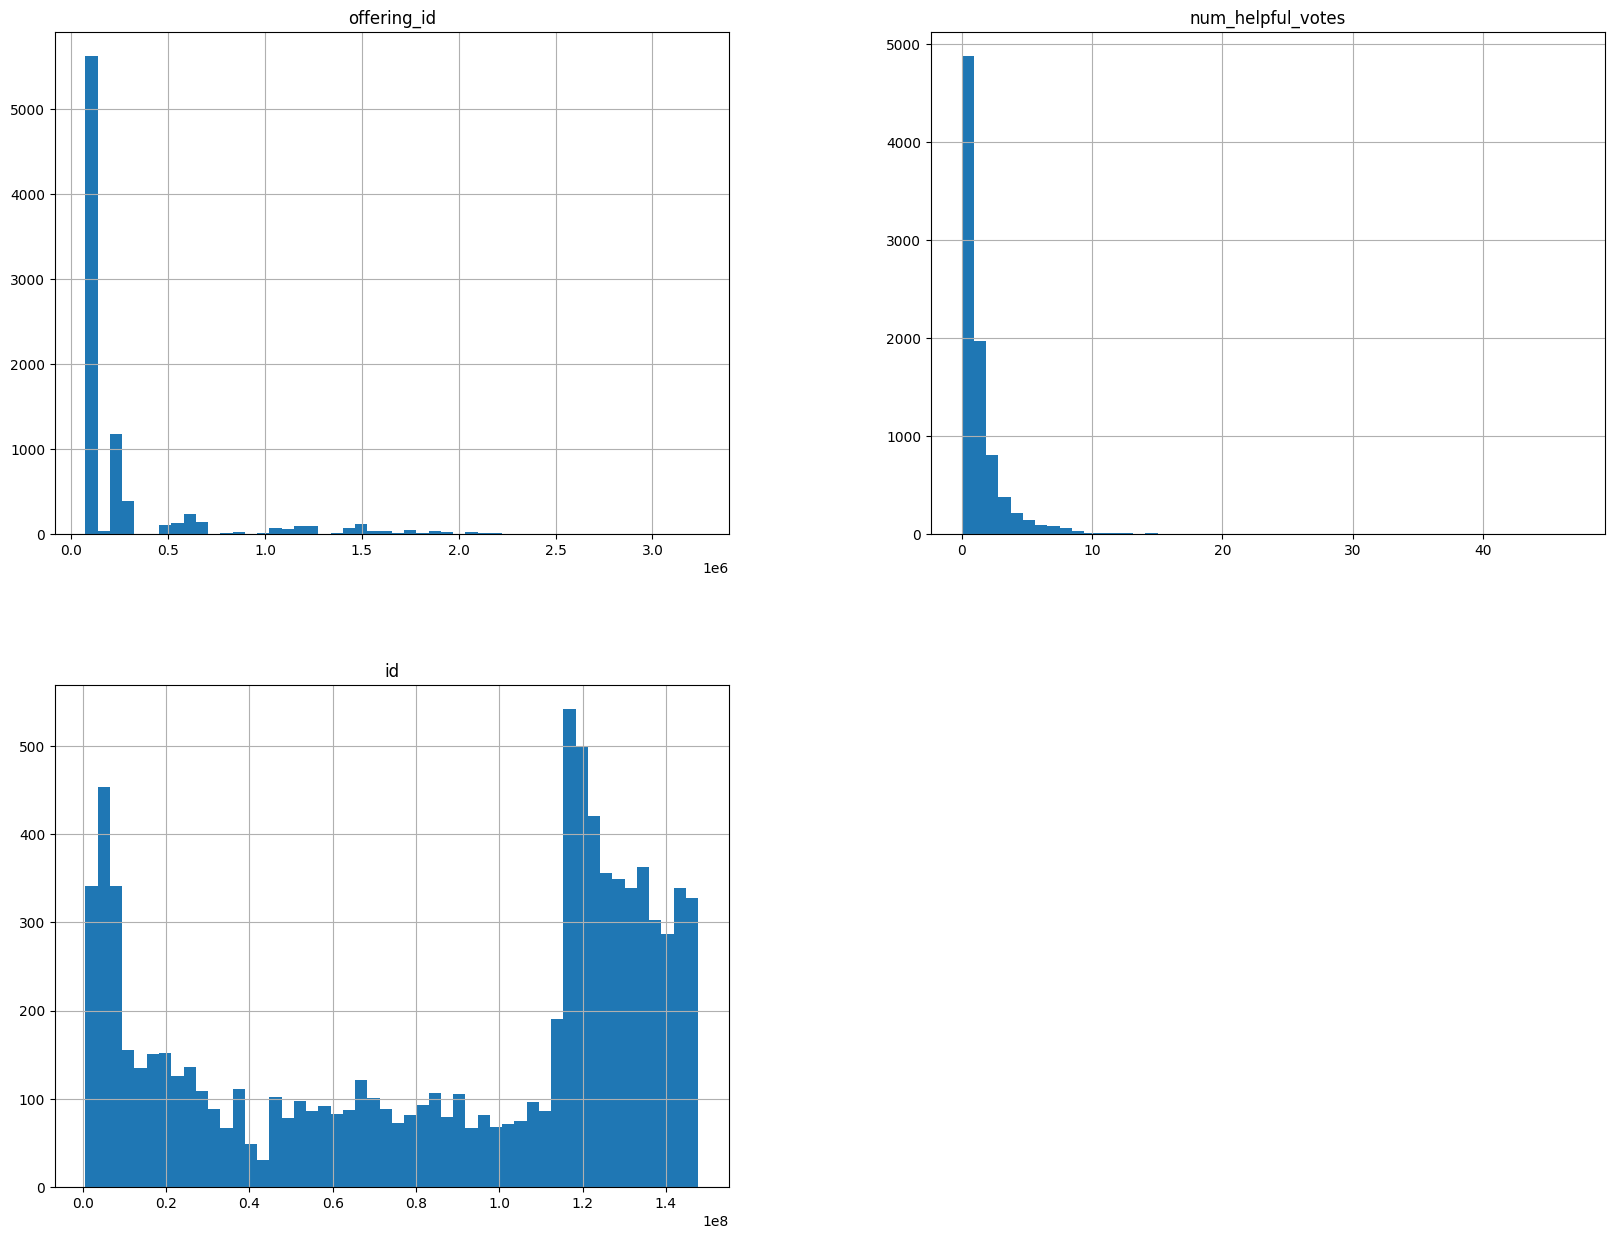

In [77]:
df.hist(bins=50,figsize=(20,15))

In [78]:
#ratings   
#title
#text   
#author  
#date_stayed
#date
#via_mobile
df.value_counts()


ratings                                                                                                                  title                                                                 text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [79]:
#결측치 확인하기 
null_counts = df.isnull().sum()
print(null_counts)

#TODO : date_stayed도 살펴보기

ratings                0
title                  0
text                   0
author                 0
date_stayed          658
offering_id            0
num_helpful_votes      0
date                   0
id                     0
via_mobile             0
dtype: int64


In [90]:
def read_and_sampling():
    df = pd.read_csv('../dataset/240128_TripAdvisorHotelReviews/reviews.csv')
    df = df.sample(frac=0.01, random_state=42)
    return df

# ratings 칼럼 처리하기 
1. ratings가 Json으로 이루어져 있으니 ratings json을 ratings_service, ratings_overall 이런식으로 각각 컬럼으로 만들어주자. 
문제점 
1. chat-gpt를 통해 json_normalize(df['ratings'])를 해주면 된다는 것을 알게 되었으나 json_normalize 해주어도 정상적으로 나누어지지 않음. 
2. 알고 봤더니 ratings안에 있던건 dict가 아니라 str 타입이어서 우선 이걸 dict타입으로 바꿔주었음.
3. 그 다음 df['ratings'].apply(lambda x: {k.replace("'", "\""): v for k, v in x.items()}) 이 과정을 통해 '' -> ""로 바꿔줌.
4. 이렇게까지 하고 나면 json_normalize를 할 수 있음. 
5. 이렇게 json_normalize를 하고 나서 만들어진 normalized_ratings df를 원본 df와 합치려고 했으나 제대로 합쳐지지 않음. 알고봤더니 공통 인덱스가 없었음.
6. id, offering_id를 key로 사용할 수 있나? 해서 확인해 봤으나 사용할 수 없음. 
7. 결국 행 번호를 인덱스로 만들어줌. 

In [80]:
type(df['ratings'].iloc[0])

str

In [99]:
df = read_and_sampling()

### json_normalize 로 json -> 각각의 칼럼으로 만들어주기 

In [100]:
#str 형식에서 json형식으로 바꿔주기 
df['ratings'] = df['ratings'].apply(lambda x: json.loads(x.replace("'", "\"")) if isinstance(x, str) else x)

#replace를 통해 '' -> ""로 바꿔주기 
df['ratings'] = df['ratings'].apply(lambda x: {k.replace("'", "\""): v for k, v in x.items()})

#json_normalize를 통해 하나의 json을 각 컬럼으로 펼치기 
#TODO : NaN으로 채우기 
normalized_ratings = json_normalize(df['ratings'],meta = ['title','text','author','date_stayed','offering_id','num_helpful_votes','date','id','via_mobile']).fillna(0)

#새로 만든 normalized_ratings의 칼럼들 이름을 ratings+ ___ 로 바꿔주기 
normalized_ratings.columns = ['ratings_' + col for col in normalized_ratings.columns]
normalized_ratings

ratings_service  ratings_cleanliness  ratings_overall  ratings_value  \
0                 5.0                  5.0              5.0            4.0   
1                 5.0                  5.0              4.0            5.0   
2                 2.0                  3.0              3.0            3.0   
3                 2.0                  2.0              2.0            2.0   
4                 2.0                  2.0              2.0            4.0   
...               ...                  ...              ...            ...   
8781              5.0                  5.0              5.0            3.0   
8782              4.0                  5.0              4.0            3.0   
8783              4.0                  5.0              4.0            5.0   
8784              0.0                  0.0              5.0            0.0   
8785              1.0                  1.0              1.0            1.0   

      ratings_location  ratings_sleep_quality  ratings_rooms  \
0                  5.0                    5.0            4.0   
1                  5.0                    0.0            5.0   
2                  5.0                    0.0            2.0   
3                  5.0                    2.0            2.0   
4                  3.0                    2.0            2.0   
...                ...                    ...            ...   
8781               3.0                    5.0            5.0   
8782               5.0                    5.0            5.0   
8783               4.0                    4.0            5.0   
8784               0.0                    0.0            0.0   
8785               4.0                    0.0            1.0   

      ratings_check_in_front_desk  \
0                             0.0   
1                             0.0   
2                             2.0   
3                             0.0   
4                             0.0   
...                           ...   
8781                          0.0   
8782                          0.0   
8783                          0.0   
8784                          0.0   
8785                          0.0   

      ratings_business_service_(e_g_internet_access)  
0                                                0.0  
1                                                0.0  
2                                                0.0  
3                                                0.0  
4                                                0.0  
...                                              ...  
8781                                             0.0  
8782                                             0.0  
8783                                             0.0  
8784                                             0.0  
8785                                             0.0  

[8786 rows x 9 columns]

### id, offering_id를 인덱스로 사용할 수 있는지 확인하기 

- 확인했지만 사용할 수 없음. 

In [88]:
# 'id' 열의 고유한 값 확인
unique_ids = df['id'].unique()

# 'id' 열이 유니크한지 확인
is_unique = len(unique_ids) == len(df['id'])

print(f"Unique IDs: {unique_ids}")
print(f"Is 'id' column unique? {is_unique}")

Unique IDs: [84800976. 46861760. 10172355. ...  8693338. 37094987.       nan]
Is 'id' column unique? False


In [89]:
# 'id' 열의 고유한 값 확인
unique_ids = df['offering_id'].unique()

# 'id' 열이 유니크한지 확인
is_unique = len(unique_ids) == len(df['offering_id'])

print(f"Unique IDs: {unique_ids}")
print(f"Is 'id' column unique? {is_unique}")

Unique IDs: [ 111492.  108562.   94354. ... 1144554.  109571.      nan]
Is 'id' column unique? False


### 기본 행 번호를 인덱스로 설정해주기 

In [102]:
print(df.index)
print(normalized_ratings.index)

Index([340013, 477333, 755575, 709674, 799143, 505431, 412029,  65984, 460171,
       434514,
       ...
       557012, 629886, 309669, 558483, 791826, 503870, 616088, 198438,  24125,
       189080],
      dtype='int64', length=8786)
RangeIndex(start=0, stop=8786, step=1)


In [103]:
# df의 인덱스를 행 번호로 통일
df.reset_index(inplace=True, drop=True)
#TODO : drop을 해줘도 되는걸까? 생각해보기 

# normalized_ratings의 인덱스를 행 번호로 통일
normalized_ratings.reset_index(inplace=True, drop=True)

print("df의 인덱스:", df.index)
print("normalized_ratings의 인덱스:", normalized_ratings.index)

df의 인덱스: RangeIndex(start=0, stop=8786, step=1)
normalized_ratings의 인덱스: RangeIndex(start=0, stop=8786, step=1)


### 새로 만든 normalized_ratings df와 원본 df를 열 방향으로 합치기 

In [104]:
df = pd.concat([df, normalized_ratings], axis=1)
df

ratings  \
0     {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
1     {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
2     {'service': 2.0, 'cleanliness': 3.0, 'overall'...   
3     {'service': 2.0, 'cleanliness': 2.0, 'overall'...   
4     {'service': 2.0, 'cleanliness': 2.0, 'overall'...   
...                                                 ...   
8781  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
8782  {'service': 4.0, 'cleanliness': 5.0, 'overall'...   
8783  {'service': 4.0, 'cleanliness': 5.0, 'overall'...   
8784                                   {'overall': 5.0}   
8785  {'service': 1.0, 'cleanliness': 1.0, 'overall'...   

                                                  title  \
0     “Very nice experience for a country boy going ...   
1                                     “Great Courtyard”   
2                       “Location, location, location!”   
3     “This place is run down, not taken care of at ...   
4                     “The good, the bad and the ugly.”   
...                                                 ...   
8781                                “Fantastic Service”   
8782   “If you get the good rooms, the view is awesome”   
8783   “Super Hotel in New York - Real value for money”   
8784                          “Ultimate New York Hotel”   
8785                                            “AWFUL”   

                                                   text  \
0     Being from a small town in Tennessee, I was ve...   
1     I stayed at this courtyard for 2 nights . Ever...   
2     Even in Boston for $180 plus taxes per night y...   
3     This hotel is a great old building (formerly t...   
4     The Good~room was larger than expected, free i...   
...                                                 ...   
8781  We stayed at the Grand del Mar because my husb...   
8782  Firstly, I find that San Francisco hotels gene...   
8783  Rooms very clean and big for new york standard...   
8784  My wife and I spent an anniversary here last O...   
8785  Rooms dirty and small. No customer service. In...   

                                                 author     date_stayed  \
0     {'username': 'Tucker124', 'num_reviews': 1, 'i...    October 2010   
1     {'username': 'bimbotrip', 'num_reviews': 1, 'i...    October 2009   
2     {'username': 'marknthedark', 'num_cities': 17,...  September 2007   
3     {'username': 'Largeandy', 'num_cities': 16, 'n...   February 2012   
4     {'username': 'bigdog717', 'num_cities': 2, 'nu...       July 2010   
...                                                 ...             ...   
8781  {'username': 'Ontario_Sun_lovers', 'num_cities...       June 2010   
8782  {'username': 'mark_mb', 'num_cities': 21, 'num...        May 2010   
8783  {'username': 'DenmarkTraveler', 'num_reviews':...   December 2009   
8784  {'username': 'Steven_Goldberg', 'num_reviews':...    October 2006   
8785  {'username': 'carengur', 'num_reviews': 1, 'id...      April 2009   

      offering_id  num_helpful_votes        date         id  via_mobile  \
0          111492                  2  2010-10-25   84800976       False   
1          108562                  0  2009-10-14   46861760       False   
2           94354                  1  2007-10-20   10172355       False   
3           98798                  2  2012-02-09  124329781       False   
4           93889                  0  2010-07-06   69904714       False   
...           ...                ...         ...        ...         ...   
8781       781627                  0  2010-06-22   68326910       False   
8782        81295                  1  2010-10-23   84568810       False   
8783      1060157                  0  2010-02-09   55572710       False   
8784       224224                  7  2007-09-11    8693338       False   
8785        99288                  0  2009-08-08   37094987       False   

      ratings_service  ratings_cleanliness  ratings_overall  ratings_value  \
0                 5.0                  5.

## 시각화 

### 히스토그램 그리기

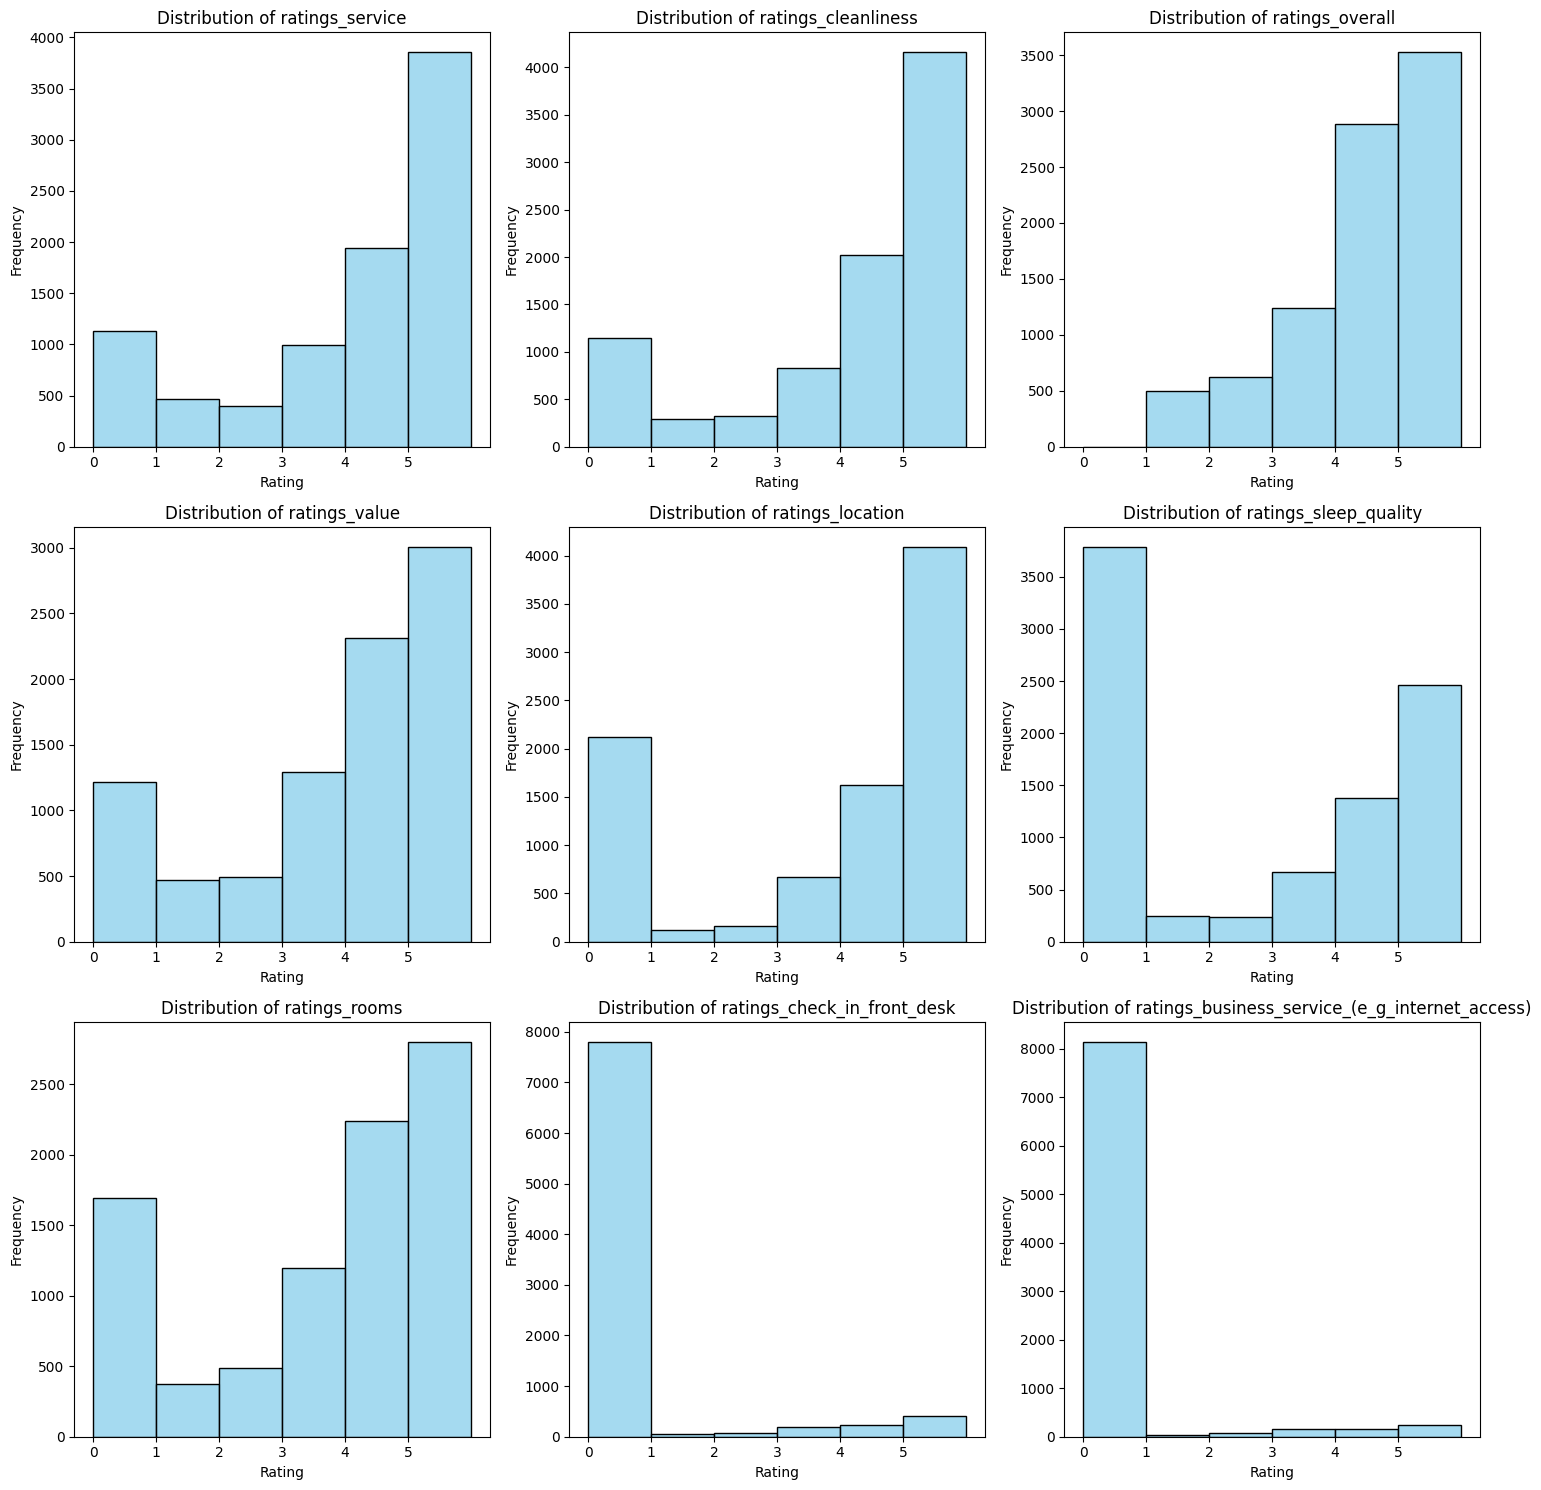

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

# ratings_로 시작하는 모든 칼럼에 대한 히스토그램 그리기
ratings_columns = df.filter(regex='^ratings_')

# 서브플롯 설정
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# 각 칼럼에 대한 히스토그램 그리기
for i, col in enumerate(ratings_columns.columns):
    sns.histplot(df[col], bins=[0, 1, 2, 3, 4, 5, 6], kde=False, color='skyblue', edgecolor='black', ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Distribution of {col}')
    axes[i//3, i%3].set_xlabel('Rating')
    axes[i//3, i%3].set_ylabel('Frequency')
    axes[i//3, i%3].set_xticks(range(6))
    axes[i//3, i%3].set_xticklabels(['0', '1', '2', '3', '4', '5'])

# 레이아웃 조정
plt.tight_layout()
plt.show()


결론
- check_in_front_desk, business_service의 경우 체크하지 않음 (0으로 초기화) 값이 너무 많아 나중에 모델에 넣고 돌릴 때 제외할 예정

### 박스플롯

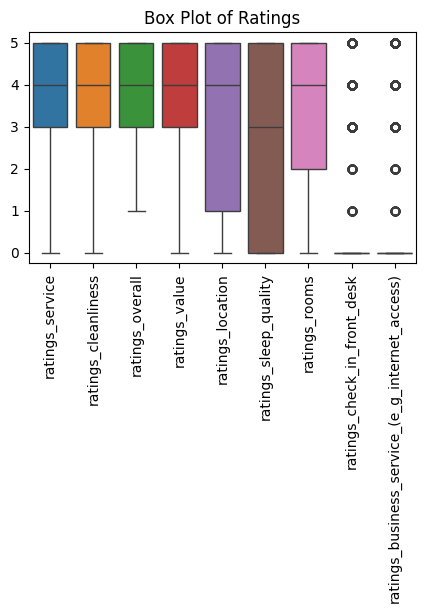

In [119]:
# ratings_로 시작하는 평가 항목들에 대한 박스 플롯
ratings_columns = df.filter(regex='^ratings_')
plt.figure(figsize=(5, 3))
sns.boxplot(data=ratings_columns)
plt.title('Box Plot of Ratings')
plt.xticks(rotation=90)
plt.show()

### 히트맵

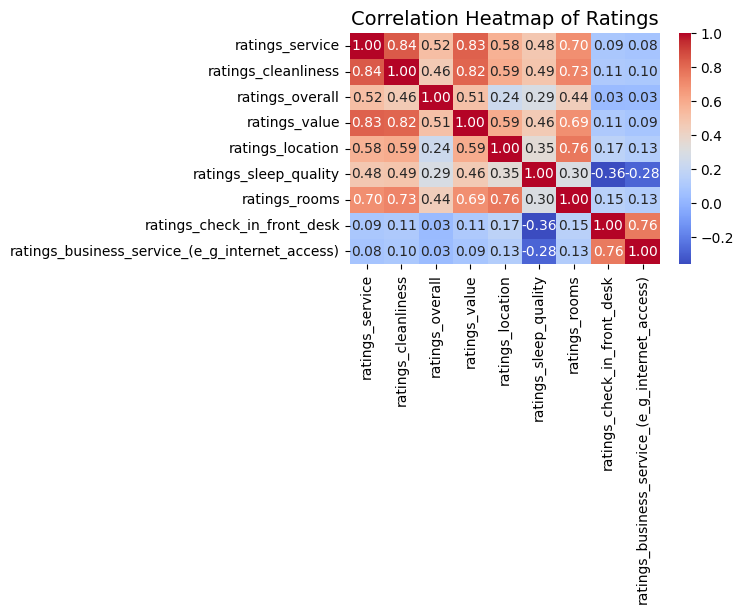

In [122]:
correlation_matrix = ratings_columns.corr()
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Ratings',fontsize=14)
plt.show()

# title 칼럼 처리하기

### 전체 title 칼럼 word cloud로 그려보기

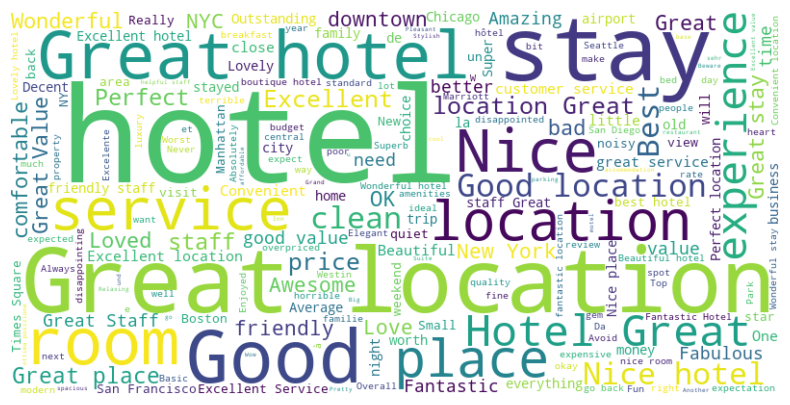

In [131]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 모든 제목을 하나의 문자열로 결합
all_titles = ' '.join(df['title'].astype(str))

# Word Cloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### ratings_overall 점수에 따라 word cloud 그려보기

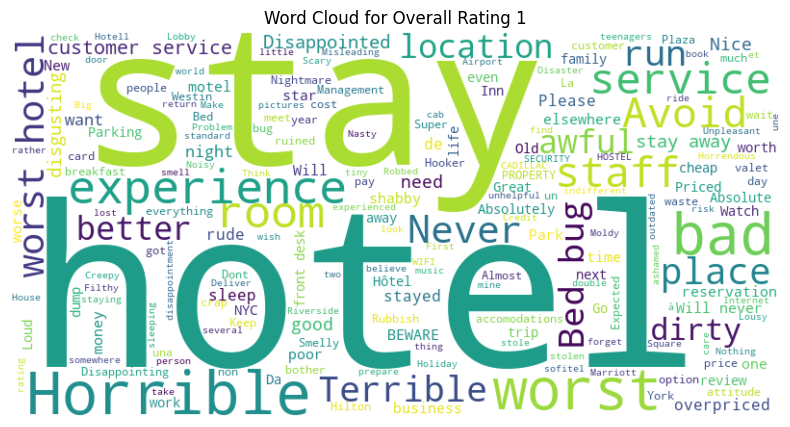

In [132]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 만족도가 1점인 데이터 추출
titles_1 = ' '.join(df[df['ratings_overall'] == 1]['title'].astype(str))

# Word Cloud 생성
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(titles_1)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Word Cloud for Overall Rating 1')
plt.axis('off')
plt.show()


### word cloud보다는 상위 10개 단어만 추출해서 비교해보기 

In [138]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/songye/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [135]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# NLTK의 불용어 다운로드
import nltk
nltk.download('stopwords')

# 불용어 설정
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/songye/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [139]:
# 만족도가 1점인 데이터 추출
titles_1 = ' '.join(df[df['ratings_overall'] == 1]['title'].astype(str))

# 불용어 제외하고 자주 등장하는 단어 확인
tokens_1 = word_tokenize(titles_1)
filtered_tokens_1 = [word.lower() for word in tokens_1 if word.isalpha() and word.lower() not in stop_words]

# 자주 등장하는 단어 확인
word_freq_1 = Counter(filtered_tokens_1)
print(word_freq_1.most_common(10))

[('hotel', 74), ('stay', 65), ('worst', 40), ('service', 30), ('ever', 27), ('horrible', 26), ('bad', 25), ('experience', 22), ('never', 21), ('avoid', 19)]


In [141]:
# 기존 불용어에 추가할 사용자 정의 불용어 리스트
custom_stop_words = ['hotel']

# 기존 불용어에 사용자 정의 불용어 추가
stop_words = set(stopwords.words('english') + custom_stop_words)

In [142]:
# 만족도별로 자주 등장하는 단어 확인하는 함수
def frequent_words_by_rating(rating):
    # 해당 만족도의 데이터 추출
    titles_by_rating = ' '.join(df[df['ratings_overall'] == rating]['title'].astype(str))

    # 토큰화 및 불용어 제거
    tokens = word_tokenize(titles_by_rating)
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

    # 자주 등장하는 단어 확인
    word_freq = Counter(filtered_tokens)

    # 가장 자주 등장하는 단어 10개 출력
    print(f'Most frequent words for Overall Rating {rating}:')
    print(word_freq.most_common(10))
    print()

# 각 만족도별로 자주 등장하는 단어 확인
for rating in range(1, 6):
    frequent_words_by_rating(rating)


Most frequent words for Overall Rating 1:
[('stay', 65), ('worst', 40), ('service', 30), ('ever', 27), ('horrible', 26), ('bad', 25), ('experience', 22), ('never', 21), ('avoid', 19), ('staff', 18)]

Most frequent words for Overall Rating 2:
[('stay', 43), ('great', 37), ('location', 36), ('service', 36), ('good', 30), ('poor', 26), ('room', 24), ('staff', 21), ('bad', 19), ('disappointed', 19)]

Most frequent words for Overall Rating 3:
[('location', 218), ('good', 162), ('great', 157), ('ok', 77), ('nice', 69), ('stay', 50), ('average', 44), ('rooms', 44), ('room', 42), ('bad', 42)]

Most frequent words for Overall Rating 4:
[('great', 767), ('location', 610), ('good', 387), ('nice', 302), ('stay', 268), ('value', 135), ('place', 130), ('service', 102), ('staff', 101), ('clean', 95)]

Most frequent words for Overall Rating 5:
[('great', 1018), ('location', 464), ('stay', 386), ('excellent', 255), ('service', 214), ('place', 194), ('staff', 181), ('wonderful', 164), ('best', 152), ('n

### 제목에 location이 들어간 사람들의 ratings 확인하기
워낙 overall 점수 자체가 높기 때문에 어떤 상관관계를 확인하기는 힘들다. 

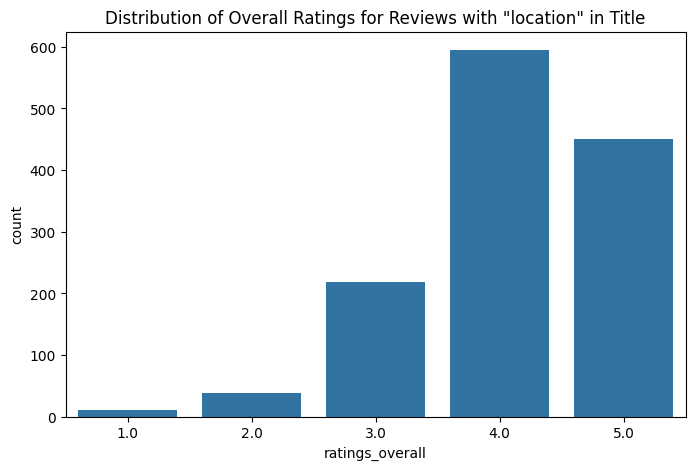

In [143]:
# 'title'에 'location'이 포함된 리뷰 추출
location_reviews = df[df['title'].str.contains('location', case=False, na=False)]

# 'ratings_overall'의 분포 확인
plt.figure(figsize=(8, 5))
sns.countplot(x='ratings_overall', data=location_reviews)
plt.title('Distribution of Overall Ratings for Reviews with "location" in Title')
plt.show()


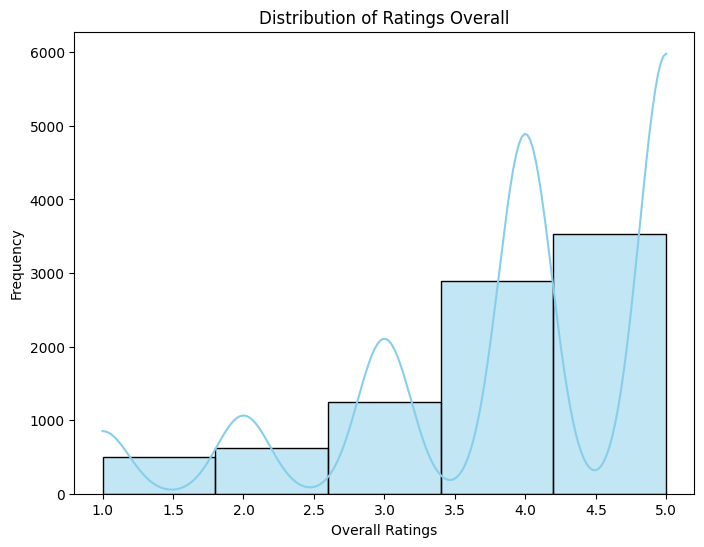

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

# ratings_overall에 해당하는 분포를 시각화
plt.figure(figsize=(8, 6))
sns.histplot(df['ratings_overall'], bins=5, kde=True, color='skyblue')
plt.title('Distribution of Ratings Overall')
plt.xlabel('Overall Ratings')
plt.ylabel('Frequency')
plt.show()


In [203]:
from scipy.stats import ttest_ind

# Location 키워드를 포함한 그룹
group_location = df[df['title'].str.contains('location', case=False)]['ratings_overall']

# Location 키워드를 포함하지 않은 그룹
group_no_location = df[~df['title'].str.contains('location', case=False)]['ratings_overall']

# t-검정 수행
t_statistic, p_value = ttest_ind(group_location, group_no_location, equal_var=False)

# 결과 출력
print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")

#TODO : t-검정 살펴보기 


T-Statistic: 6.468979111706569
P-Value: 1.1922656538797675e-10


### 그냥 빈도수 높은 어휘가 아니라 빈도수 높은 감정 어휘만을 뽑아볼 수는 없을까?

In [144]:
import nltk
from nltk.corpus import opinion_lexicon

# NLTK 데이터 다운로드
nltk.download('opinion_lexicon')
nltk.download('punkt')

# 감정 어휘 로드
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/songye/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.
[nltk_data] Downloading package punkt to /Users/songye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [145]:
# 감정 분석 함수
def analyze_sentiment(text):
    tokens = word_tokenize(text.lower())
    positive = [word for word in tokens if word in positive_words]
    negative = [word for word in tokens if word in negative_words]
    sentiment = 'positive' if len(positive) > len(negative) else 'negative' if len(negative) > len(positive) else 'neutral'
    return {
        'positive_words': positive,
        'negative_words': negative,
        'sentiment': sentiment
    }

# ratings_overall 점수에 따라 title 분류 및 감정어휘 추출
ratings = df['ratings_overall'].unique()

for rating in ratings:
    # 특정 점수에 해당하는 데이터 추출
    subset_df = df[df['ratings_overall'] == rating]
    
    # 해당 데이터의 title에 대해 감정어휘 추출
    all_positive_words = []
    all_negative_words = []
    for title in subset_df['title'].astype(str):
        result = analyze_sentiment(title)
        all_positive_words.extend(result['positive_words'])
        all_negative_words.extend(result['negative_words'])
    
    # 가장 많이 등장한 긍정어휘 및 부정어휘 10개 추출
    top_positive_words = [word for word, count in Counter(all_positive_words).most_common(10)]
    top_negative_words = [word for word, count in Counter(all_negative_words).most_common(10)]
    
    # 결과 출력
    print(f"Sentiment Analysis for Overall Rating {rating}:")
    print(f"Top 10 Positive Words: {top_positive_words}")
    print(f"Top 10 Negative Words: {top_negative_words}")
    print("\n")

    #TODO : 감정어휘 빈도별로 살펴보기 


Sentiment Analysis for Overall Rating 5.0:
Top 10 Positive Words: ['great', 'excellent', 'wonderful', 'best', 'nice', 'perfect', 'friendly', 'fantastic', 'good', 'loved']
Top 10 Negative Words: ['break', 'complaints', 'bad', 'funky', 'unexpected', 'expensive', 'pricey', 'disappoints', 'awful', 'retreat']


Sentiment Analysis for Overall Rating 4.0:
Top 10 Positive Words: ['great', 'good', 'nice', 'clean', 'excellent', 'perfect', 'comfortable', 'friendly', 'convenient', 'beautiful']
Top 10 Negative Words: ['bad', 'expensive', 'noisy', 'complaints', 'break', 'funky', 'overpriced', 'issues', 'pricey', 'wrong']


Sentiment Analysis for Overall Rating 3.0:
Top 10 Positive Words: ['good', 'great', 'nice', 'better', 'clean', 'decent', 'convenient', 'excellent', 'best', 'fine']
Top 10 Negative Words: ['bad', 'noisy', 'expensive', 'beware', 'issues', 'overpriced', 'poor', 'disappointed', 'noise', 'disappointing']


Sentiment Analysis for Overall Rating 2.0:
Top 10 Positive Words: ['great', 'goo

# text 칼럼 처리하기 

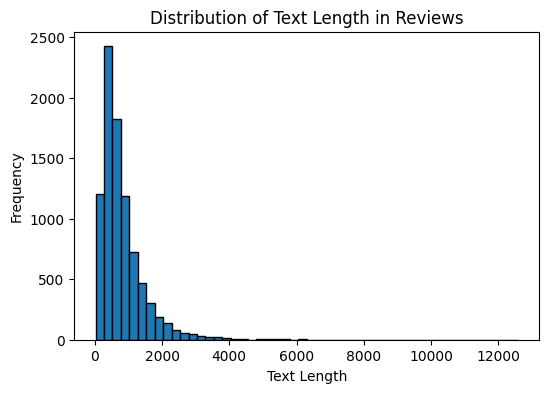

In [149]:
import matplotlib.pyplot as plt

# 각 리뷰의 text 칼럼의 길이 측정
df['text_length'] = df['text'].apply(len)

# 히스토그램으로 시각화
plt.figure(figsize=(6, 4))
plt.hist(df['text_length'], bins=50, edgecolor='black')
plt.title('Distribution of Text Length in Reviews')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


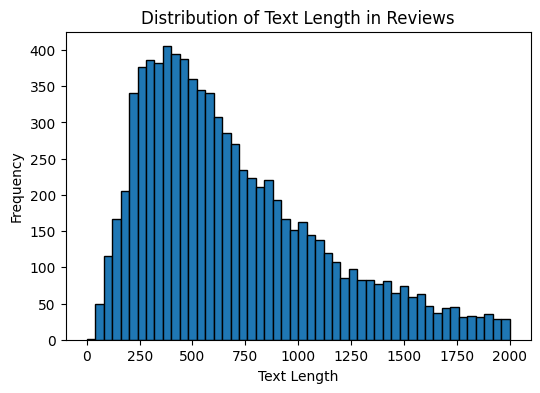

In [150]:
import matplotlib.pyplot as plt

# 각 리뷰의 text 칼럼의 길이 측정
df['text_length'] = df['text'].apply(len)

# 히스토그램으로 시각화 (중심 조절)
plt.figure(figsize=(6, 4))
plt.hist(df['text_length'], bins=50, edgecolor='black', range=(0, 2000))  # 범위를 조절하여 원하는 중심으로 이동
plt.title('Distribution of Text Length in Reviews')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


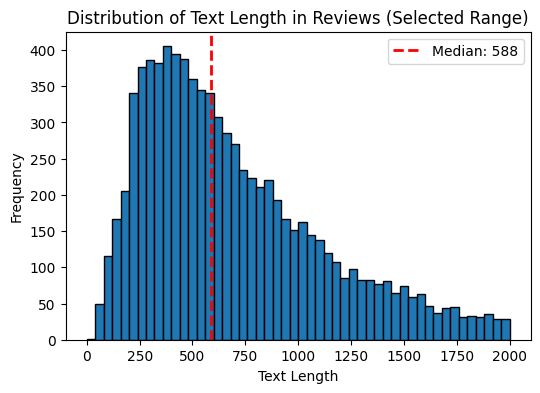

Median Text Length in the Selected Range: 588


In [154]:
import matplotlib.pyplot as plt

# 각 리뷰의 text 칼럼의 길이 측정
df['text_length'] = df['text'].apply(len)

# 주어진 범위 내의 데이터만 선택
range_start = 0
range_end = 2000
selected_data = df[(df['text_length'] >= range_start) & (df['text_length'] <= range_end)]

# 중앙값 계산
median_text_length = selected_data['text_length'].median()

# 히스토그램으로 시각화 (중심 조절)
plt.figure(figsize=(6, 4))
plt.hist(selected_data['text_length'], bins=50, edgecolor='black', range=(range_start, range_end))
plt.title('Distribution of Text Length in Reviews (Selected Range)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.axvline(median_text_length, color='red', linestyle='dashed', linewidth=2, label=f'Median: {int(median_text_length)}')
plt.legend()
plt.show()

# 중앙값 출력
print(f"Median Text Length in the Selected Range: {int(median_text_length)}")


### text의 길이와 num_helpful_votes는 어떤 관계가 있을까?
- 0.1에서 0.3: 약한 상관관계를 보인다.

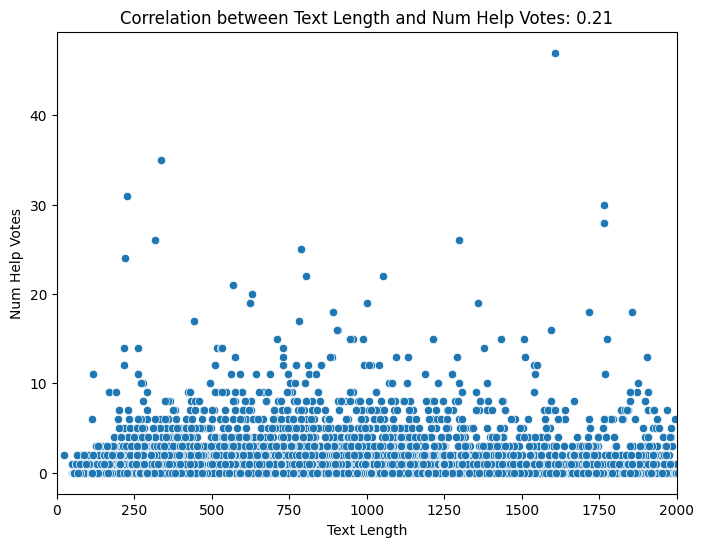

Correlation between Text Length and Num Help Votes: 0.21


In [157]:
import numpy as np
import seaborn as sns

# 각 리뷰의 text 칼럼의 길이 측정
df['text_length'] = df['text'].apply(len)

# 상관관계 계산
correlation = np.corrcoef(df['text_length'], df['num_helpful_votes'])[0, 1]

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x='text_length', y='num_helpful_votes', data=df)
plt.title(f'Correlation between Text Length and Num Help Votes: {correlation:.2f}')
plt.xlabel('Text Length')
plt.ylabel('Num Help Votes')
plt.xlim(0, 2000)  # x 축 범위 설정
plt.show()

# 상관관계 출력
print(f'Correlation between Text Length and Num Help Votes: {correlation:.2f}')


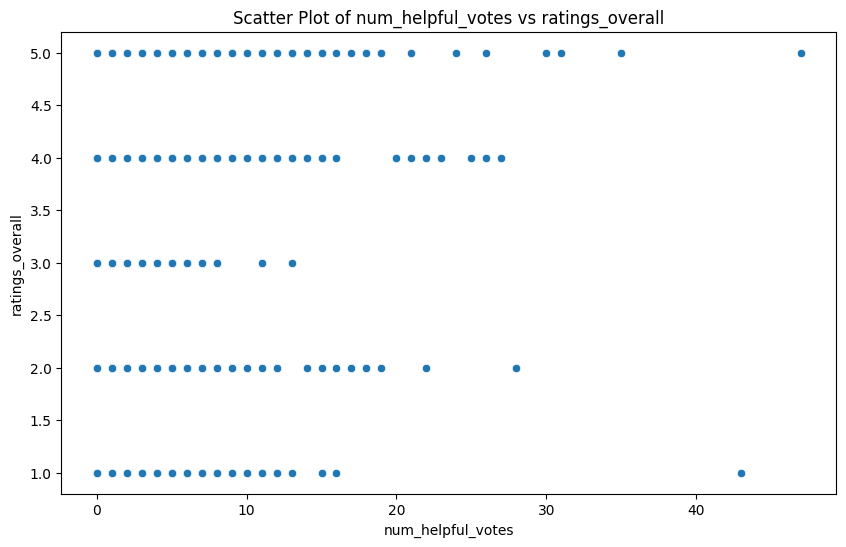

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns

# 산점도 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_helpful_votes', y='ratings_overall', data=df)
plt.title('Scatter Plot of num_helpful_votes vs ratings_overall')
plt.xlabel('num_helpful_votes')
plt.ylabel('ratings_overall')
plt.show()


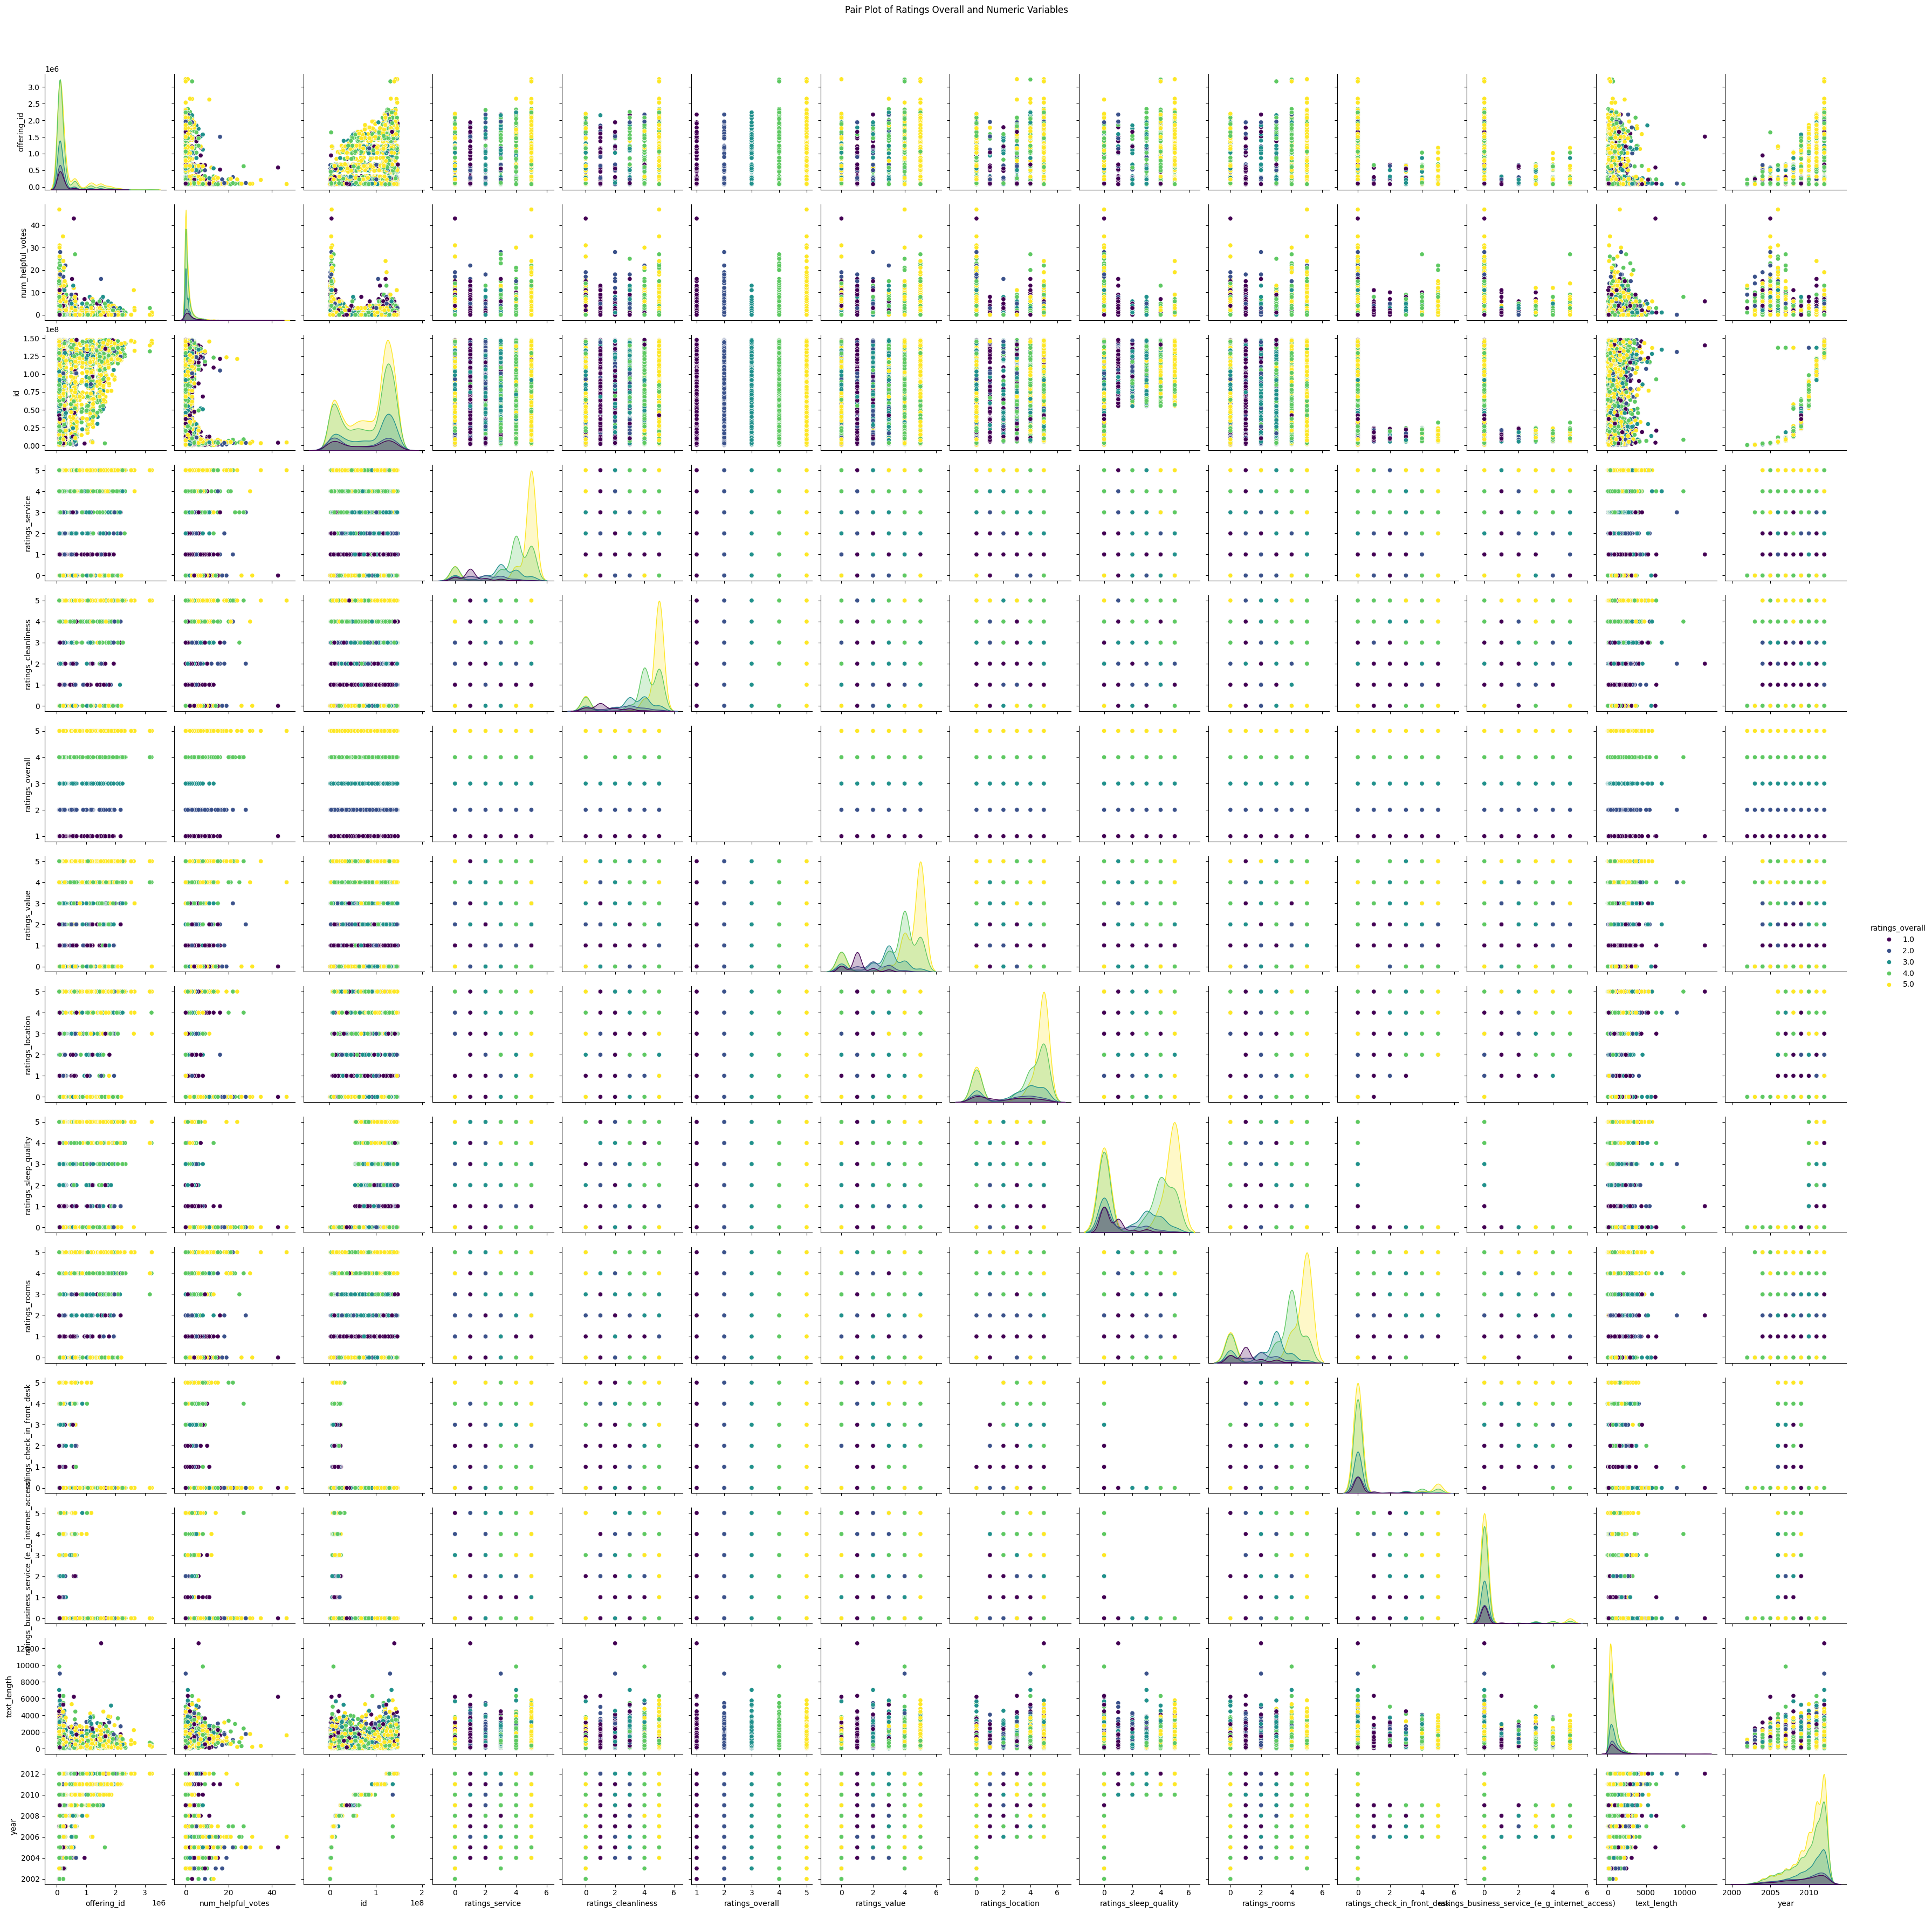

In [209]:
import seaborn as sns

# ratings_overall과 다른 숫자형 변수들 간의 상관관계 시각화
numeric_columns = df.select_dtypes(include='number').columns
sns.pairplot(df, vars=numeric_columns, hue='ratings_overall', palette='viridis')
plt.suptitle('Pair Plot of Ratings Overall and Numeric Variables', y=1.02)
plt.show()


In [155]:
df

ratings  \
0     {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
1     {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
2     {'service': 2.0, 'cleanliness': 3.0, 'overall'...   
3     {'service': 2.0, 'cleanliness': 2.0, 'overall'...   
4     {'service': 2.0, 'cleanliness': 2.0, 'overall'...   
...                                                 ...   
8781  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
8782  {'service': 4.0, 'cleanliness': 5.0, 'overall'...   
8783  {'service': 4.0, 'cleanliness': 5.0, 'overall'...   
8784                                   {'overall': 5.0}   
8785  {'service': 1.0, 'cleanliness': 1.0, 'overall'...   

                                                  title  \
0     “Very nice experience for a country boy going ...   
1                                     “Great Courtyard”   
2                       “Location, location, location!”   
3     “This place is run down, not taken care of at ...   
4                     “The good, the bad and the ugly.”   
...                                                 ...   
8781                                “Fantastic Service”   
8782   “If you get the good rooms, the view is awesome”   
8783   “Super Hotel in New York - Real value for money”   
8784                          “Ultimate New York Hotel”   
8785                                            “AWFUL”   

                                                   text  \
0     Being from a small town in Tennessee, I was ve...   
1     I stayed at this courtyard for 2 nights . Ever...   
2     Even in Boston for $180 plus taxes per night y...   
3     This hotel is a great old building (formerly t...   
4     The Good~room was larger than expected, free i...   
...                                                 ...   
8781  We stayed at the Grand del Mar because my husb...   
8782  Firstly, I find that San Francisco hotels gene...   
8783  Rooms very clean and big for new york standard...   
8784  My wife and I spent an anniversary here last O...   
8785  Rooms dirty and small. No customer service. In...   

                                                 author     date_stayed  \
0     {'username': 'Tucker124', 'num_reviews': 1, 'i...    October 2010   
1     {'username': 'bimbotrip', 'num_reviews': 1, 'i...    October 2009   
2     {'username': 'marknthedark', 'num_cities': 17,...  September 2007   
3     {'username': 'Largeandy', 'num_cities': 16, 'n...   February 2012   
4     {'username': 'bigdog717', 'num_cities': 2, 'nu...       July 2010   
...                                                 ...             ...   
8781  {'username': 'Ontario_Sun_lovers', 'num_cities...       June 2010   
8782  {'username': 'mark_mb', 'num_cities': 21, 'num...        May 2010   
8783  {'username': 'DenmarkTraveler', 'num_reviews':...   December 2009   
8784  {'username': 'Steven_Goldberg', 'num_reviews':...    October 2006   
8785  {'username': 'carengur', 'num_reviews': 1, 'id...      April 2009   

      offering_id  num_helpful_votes        date         id  via_mobile  \
0          111492                  2  2010-10-25   84800976       False   
1          108562                  0  2009-10-14   46861760       False   
2           94354                  1  2007-10-20   10172355       False   
3           98798                  2  2012-02-09  124329781       False   
4           93889                  0  2010-07-06   69904714       False   
...           ...                ...         ...        ...         ...   
8781       781627                  0  2010-06-22   68326910       False   
8782        81295                  1  2010-10-23   84568810       False   
8783      1060157                  0  2010-02-09   55572710       False   
8784       224224                  7  2007-09-11    8693338       False   
8785        99288                  0  2009-08-08   37094987       False   

      ratings_service  ratings_cleanliness  ratings_overall  ratings_value  \
0                 5.0                  5.

### 프랑스어로 적힌 리뷰글 시각화하기

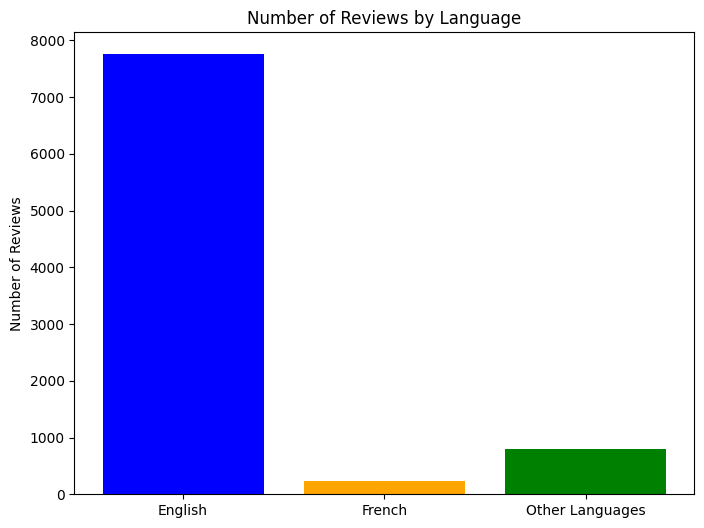

Number of reviews in English: 7754
Number of reviews in French: 240
Number of reviews in other languages: 792


In [160]:
from langdetect import detect
import matplotlib.pyplot as plt

# 각 리뷰의 text 칼럼에 대해 언어 감지
df['language'] = df['text'].apply(lambda x: detect(x) if type(x) == str else None)

# 언어별 카운트
lang_counts = df['language'].value_counts()

# 영어, 프랑스어, 그 외의 언어로 구분
english_count = lang_counts.get('en', 0)
french_count = lang_counts.get('fr', 0)
other_count = df.shape[0] - english_count - french_count

# 시각화
plt.figure(figsize=(8, 6))
plt.bar(['English', 'French', 'Other Languages'], [english_count, french_count, other_count], color=['blue', 'orange', 'green'])
plt.title('Number of Reviews by Language')
plt.ylabel('Number of Reviews')
plt.show()

# 결과 출력
print(f"Number of reviews in English: {english_count}")
print(f"Number of reviews in French: {french_count}")
print(f"Number of reviews in other languages: {other_count}")


# ratings_overall 점수에 따른 텍스트 word cloud 만들기

#TODO : 명사, 어근, 형용사 위주로 찾아보기 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/songye/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


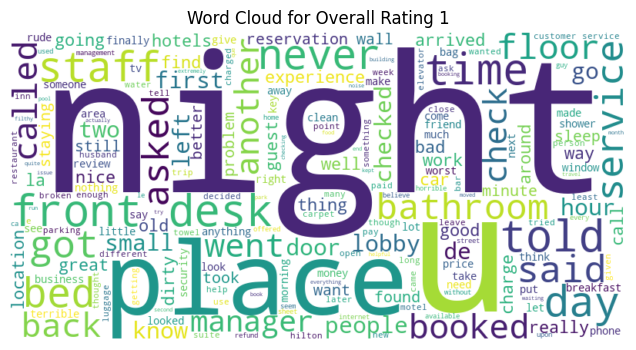

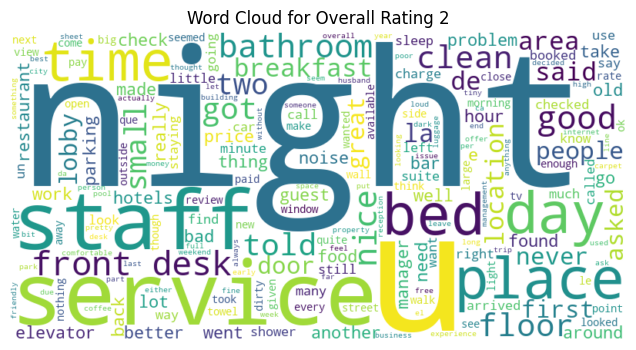

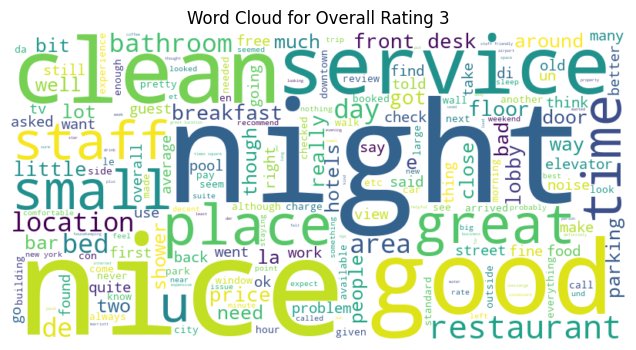

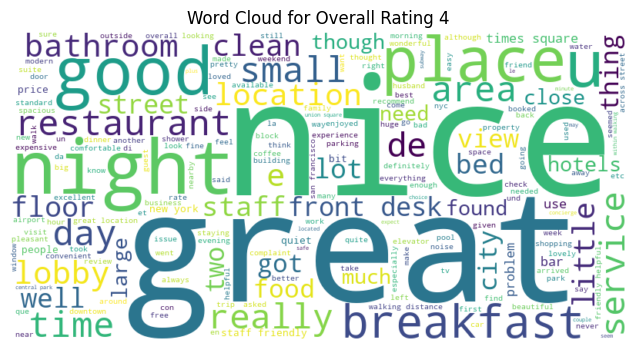

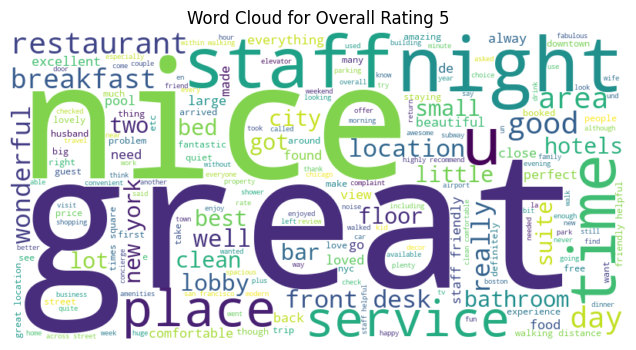

In [192]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# nltk의 불용어 다운로드
import nltk
nltk.download('stopwords')

# 불용어 설정 (rating_overall에 따라서 어떤 불용어를 사용할지는 상황에 따라 조정해야 합니다.)

additional_stop_words = ['hotel', 'stay', 'would', 'could', 'even', 'one','stay','stayed','room','rooms']

# 불용어 설정 (rating_overall에 따라서 어떤 불용어를 사용할지는 상황에 따라 조정해야 합니다.)
stop_words = set(stopwords.words('english') + additional_stop_words)

# ratings_overall 값에 따른 Word Cloud 생성 함수
def generate_wordcloud_for_rating(rating, text_column):
    # 해당 rating에 해당하는 리뷰들 선택
    subset = df[df['ratings_overall'] == rating]
    
    # 해당 리뷰들의 text 컬럼을 합치기
    text = ' '.join(subset[text_column].astype(str))
    
    # 불용어 제거 및 토큰화
    tokens = word_tokenize(text)
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    
    # Word Cloud 생성
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))
    
    # 시각화
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Overall Rating {rating}')
    plt.show()

# ratings_overall 값에 따라 Word Cloud 생성
for rating in range(1, 6):
    generate_wordcloud_for_rating(rating, 'text')


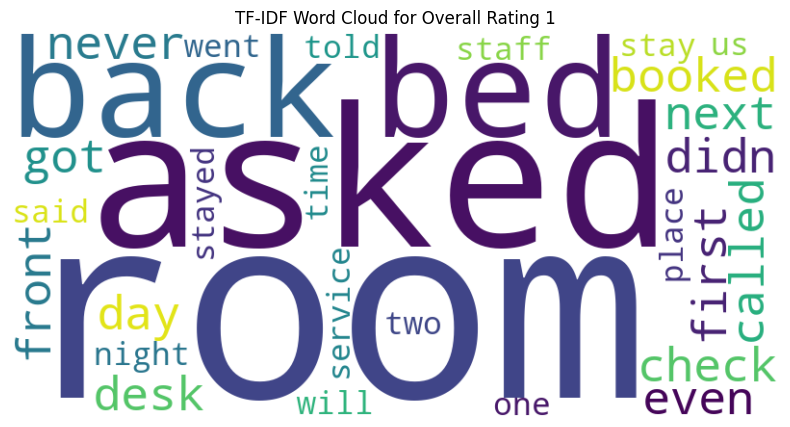

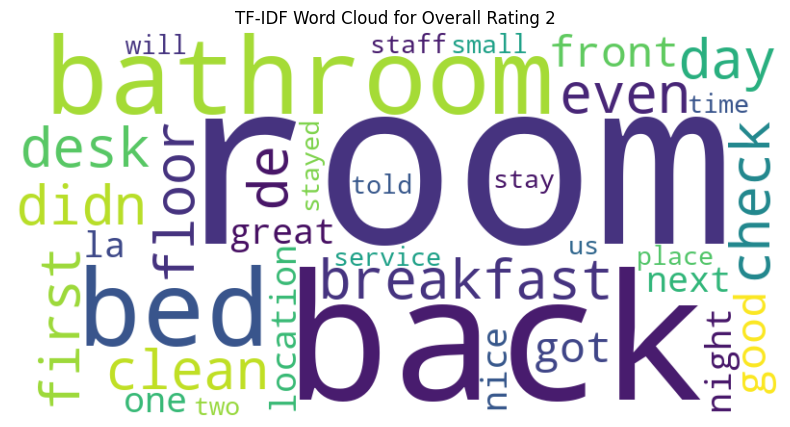

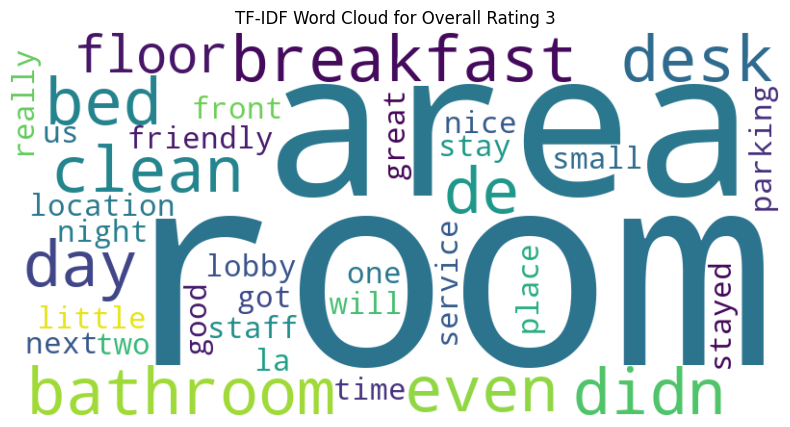

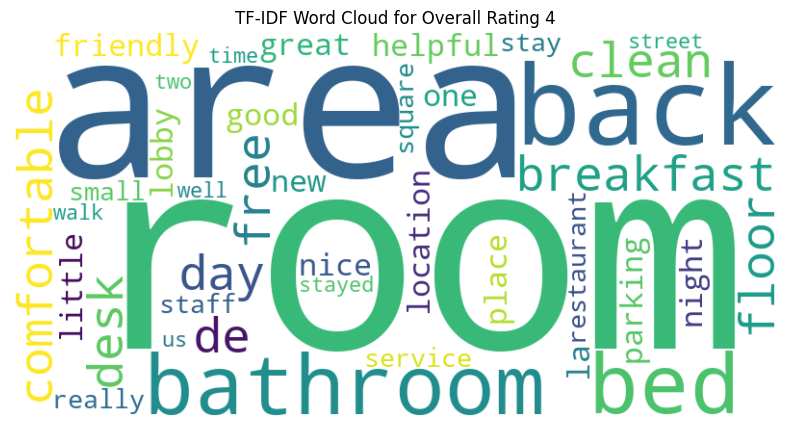

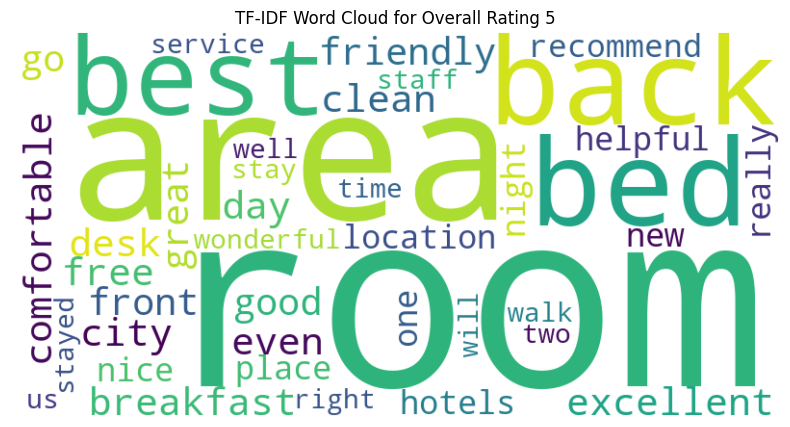

In [197]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer


additional_stop_words = ['hotel', 'stay', 'would', 'could', 'even', 'one','stay','stayed','room','rooms']

# 불용어 설정 (rating_overall에 따라서 어떤 불용어를 사용할지는 상황에 따라 조정해야 합니다.)
stop_words = set(stopwords.words('english') + additional_stop_words)

# ratings_overall 값에 따른 TF-IDF 기반 Word Cloud 생성 함수
def generate_tfidf_wordcloud_for_rating(rating, text_column):
    # 해당 rating에 해당하는 리뷰들 선택
    subset = df[df['ratings_overall'] == rating]
    
    # 해당 리뷰들의 text 컬럼을 합치기
    documents = subset[text_column].astype(str).tolist()
    
    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer(stop_words=custom_stop_words, max_features=100)
    tfidf_matrix = vectorizer.fit_transform(documents)
    
    # 각 단어와 그에 대한 TF-IDF 값을 딕셔너리로 저장
    feature_names = vectorizer.get_feature_names_out()
    tfidf_dict = dict(zip(feature_names, vectorizer.idf_))
    
    # Word Cloud에 표시할 중요한 단어들 선택
    important_words = [word for word, tfidf in tfidf_dict.items() if tfidf < 5.0]
    
    # Word Cloud 생성
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(important_words))
    
    # 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'TF-IDF Word Cloud for Overall Rating {rating}')
    plt.show()

# ratings_overall 값에 따라 TF-IDF Word Cloud 생성
for rating in range(1, 6):
    generate_tfidf_wordcloud_for_rating(rating, 'text')


#TODO : tf-idf 어떻게 되는건지 좀 더 살펴보기 


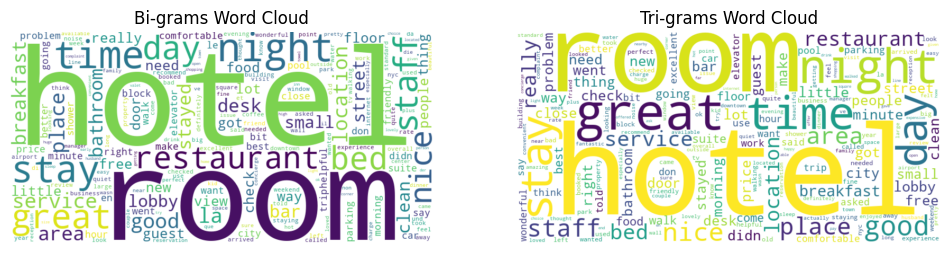

In [200]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

subset = df[df['ratings_overall'] == 1]
    
documents = subset['text'].astype(str).tolist()

# Bi-grams 설정
bi_gram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bi_gram_matrix = bi_gram_vectorizer.fit_transform(df['text'])

# Tri-grams 설정
tri_gram_vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
tri_gram_matrix = tri_gram_vectorizer.fit_transform(df['text'])

# Bi-grams와 Tri-grams의 feature names 확인
bi_gram_feature_names = bi_gram_vectorizer.get_feature_names_out()
tri_gram_feature_names = tri_gram_vectorizer.get_feature_names_out()

# Bi-grams와 Tri-grams 시각화
bi_gram_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(bi_gram_feature_names))
tri_gram_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tri_gram_feature_names))

# 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(bi_gram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Bi-grams Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(tri_gram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tri-grams Word Cloud')

plt.show()


#TODO : bigram, tigram인데 왜 단어가 하나씩 나오는지 살펴보기 


# 날짜 데이터 시각화하기

In [161]:
# 날짜 칼럼을 datetime 형식으로 변환
df['date'] = pd.to_datetime(df['date'])
df

ratings  \
0     {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
1     {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
2     {'service': 2.0, 'cleanliness': 3.0, 'overall'...   
3     {'service': 2.0, 'cleanliness': 2.0, 'overall'...   
4     {'service': 2.0, 'cleanliness': 2.0, 'overall'...   
...                                                 ...   
8781  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
8782  {'service': 4.0, 'cleanliness': 5.0, 'overall'...   
8783  {'service': 4.0, 'cleanliness': 5.0, 'overall'...   
8784                                   {'overall': 5.0}   
8785  {'service': 1.0, 'cleanliness': 1.0, 'overall'...   

                                                  title  \
0     “Very nice experience for a country boy going ...   
1                                     “Great Courtyard”   
2                       “Location, location, location!”   
3     “This place is run down, not taken care of at ...   
4                     “The good, the bad and the ugly.”   
...                                                 ...   
8781                                “Fantastic Service”   
8782   “If you get the good rooms, the view is awesome”   
8783   “Super Hotel in New York - Real value for money”   
8784                          “Ultimate New York Hotel”   
8785                                            “AWFUL”   

                                                   text  \
0     Being from a small town in Tennessee, I was ve...   
1     I stayed at this courtyard for 2 nights . Ever...   
2     Even in Boston for $180 plus taxes per night y...   
3     This hotel is a great old building (formerly t...   
4     The Good~room was larger than expected, free i...   
...                                                 ...   
8781  We stayed at the Grand del Mar because my husb...   
8782  Firstly, I find that San Francisco hotels gene...   
8783  Rooms very clean and big for new york standard...   
8784  My wife and I spent an anniversary here last O...   
8785  Rooms dirty and small. No customer service. In...   

                                                 author     date_stayed  \
0     {'username': 'Tucker124', 'num_reviews': 1, 'i...    October 2010   
1     {'username': 'bimbotrip', 'num_reviews': 1, 'i...    October 2009   
2     {'username': 'marknthedark', 'num_cities': 17,...  September 2007   
3     {'username': 'Largeandy', 'num_cities': 16, 'n...   February 2012   
4     {'username': 'bigdog717', 'num_cities': 2, 'nu...       July 2010   
...                                                 ...             ...   
8781  {'username': 'Ontario_Sun_lovers', 'num_cities...       June 2010   
8782  {'username': 'mark_mb', 'num_cities': 21, 'num...        May 2010   
8783  {'username': 'DenmarkTraveler', 'num_reviews':...   December 2009   
8784  {'username': 'Steven_Goldberg', 'num_reviews':...    October 2006   
8785  {'username': 'carengur', 'num_reviews': 1, 'id...      April 2009   

      offering_id  num_helpful_votes       date         id  via_mobile  ...  \
0          111492                  2 2010-10-25   84800976       False  ...   
1          108562                  0 2009-10-14   46861760       False  ...   
2           94354                  1 2007-10-20   10172355       False  ...   
3           98798                  2 2012-02-09  124329781       False  ...   
4           93889                  0 2010-07-06   69904714       False  ...   
...           ...                ...        ...        ...         ...  ...   
8781       781627                  0 2010-06-22   68326910       False  ...   
8782        81295                  1 2010-10-23   84568810       False  ...   
8783      1060157                  0 2010-02-09   55572710       False  ...   
8784       224224                  7 2007-09-11    8693338       False  ...   
8785        99288                  0 2009-08-08   37094987       False  ...   

      ratings_cleanliness  ratings_overall  ratings_value  ratings_loca

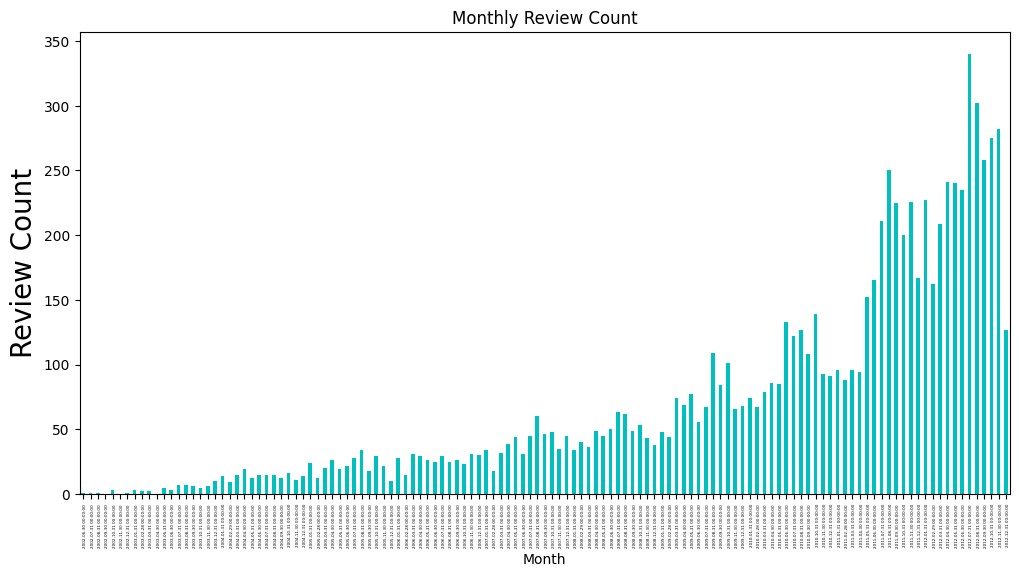

In [174]:
# 날짜 칼럼을 datetime 형식으로 변환
df['date'] = pd.to_datetime(df['date'])

# 날짜를 기반으로 월별 리뷰 수 계산
monthly_review_count = df.resample('M', on='date').size()

# 월별 리뷰 수 시각화
plt.figure(figsize=(12, 6))
monthly_review_count.plot(kind='bar', color='c')
plt.title('Monthly Review Count')
plt.xlabel('Month',fontsize=10)
plt.ylabel('Review Count',fontsize=20)
plt.xticks(rotation_mode='anchor', ha='right',fontsize=3)
plt.show()


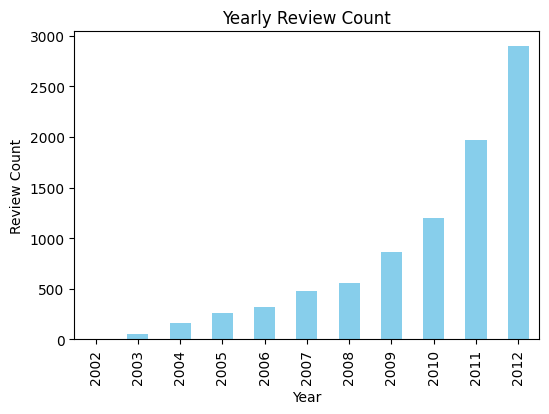

In [176]:
# 날짜 칼럼을 datetime 형식으로 변환
df['date'] = pd.to_datetime(df['date'])

# 연도별 리뷰 수 계산
df['year'] = df['date'].dt.year
yearly_review_count = df['year'].value_counts().sort_index()

# 연도별 리뷰 수 시각화
plt.figure(figsize=(6, 4))
yearly_review_count.plot(kind='bar', color='skyblue')
plt.title('Yearly Review Count')
plt.xlabel('Year')
plt.ylabel('Review Count')
plt.show()


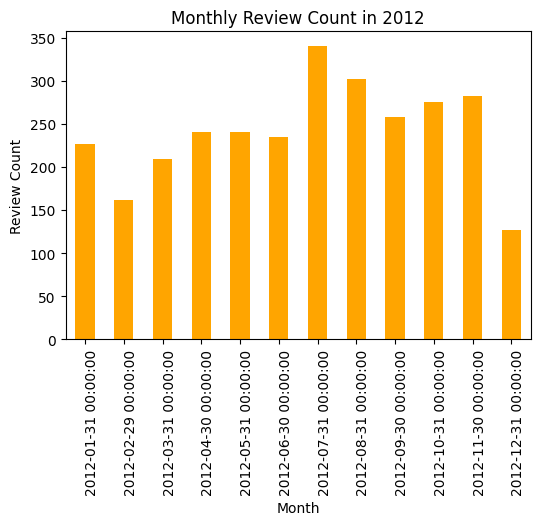

In [178]:
# 2012년도의 리뷰 추이 시각화
reviews_2012 = df[df['year'] == 2012]
monthly_review_count_2012 = reviews_2012.resample('M', on='date').size()

plt.figure(figsize=(6, 4))
monthly_review_count_2012.plot(kind='bar', color='orange')
plt.title('Monthly Review Count in 2012')
plt.xlabel('Month')
plt.ylabel('Review Count')
plt.xticks(rotation_mode='anchor', ha='right')
plt.show()


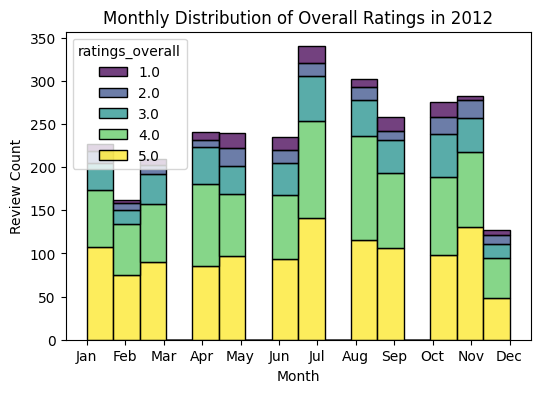

In [184]:
import seaborn as sns

# 2012년도의 리뷰 추이 시각화 (누적 바 그래프)
plt.figure(figsize=(6, 4))
ax = sns.histplot(data=reviews_2012, x=reviews_2012['date'].dt.month, hue='ratings_overall', multiple='stack', palette='viridis', stat='count', common_norm=False)
plt.title('Monthly Distribution of Overall Ratings in 2012')
plt.xlabel('Month')
plt.ylabel('Review Count')

# xticks 모두 표시
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()


# author 분석하기

In [204]:
type(df['author'].iloc[0])

str

In [210]:
import json
from pandas import json_normalize

def parse_json(x):
    try:
        return json.loads(x.replace("'", "\"")) if isinstance(x, str) else x
    except json.JSONDecodeError:
        # JSON 형식이 아닌 경우 예외 처리
        return None

# author 컬럼에 대해 JSON 파싱 수행
df['author'] = df['author'].apply(parse_json)

# JSON 파싱이 실패한 경우 해당 행 삭제
df = df.dropna(subset=['author'])

# json_normalize를 통해 하나의 JSON을 각 컬럼으로 펼치기
normalized_author = json_normalize(df['author']).fillna(0)

# 새로 만든 normalized_author의 칼럼들 이름을 'author_'로 바꿔주기
normalized_author.columns = ['author_' + col for col in normalized_author.columns]

# 결과 확인
print(normalized_author)


         author_username  author_num_reviews  \
0              Tucker124                 1.0   
1              bimbotrip                 1.0   
2           marknthedark                20.0   
3              Largeandy                32.0   
4              bigdog717                 2.0   
...                  ...                 ...   
8768  Ontario_Sun_lovers                28.0   
8769             mark_mb                23.0   
8770     DenmarkTraveler                 1.0   
8771     Steven_Goldberg                 1.0   
8772            carengur                 1.0   

                             author_id      author_location  \
0     39AA7B174D045F1E2BAE8A398D00BBC2    Martin, Tennessee   
1     88E51140F05E96098AB1F8CF3976B691               Mexico   
2     F59724E77C3653E0FADF38D34EDCB122        Bangor, Maine   
3     74BE69EB45669EDA448297E922E7160D              Ruidoso   
4     22703108484AF7F632C053172E5B9E1C   Bayville, New York   
...                                ...       

In [211]:
df.shape

(8773, 22)

In [213]:
# df의 인덱스를 행 번호로 통일
df.reset_index(inplace=True, drop=True)

# normalized_ratings의 인덱스를 행 번호로 통일
normalized_author.reset_index(inplace=True, drop=True)

print("df의 인덱스:", df.index)
print("normalized_ratings의 인덱스:", normalized_ratings.index)

df의 인덱스: RangeIndex(start=0, stop=8773, step=1)
normalized_ratings의 인덱스: RangeIndex(start=0, stop=8786, step=1)


In [214]:
df = pd.concat([df, normalized_author], axis=1)
df.head(3)

ratings  \
0  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
1  {'service': 5.0, 'cleanliness': 5.0, 'overall'...   
2  {'service': 2.0, 'cleanliness': 3.0, 'overall'...   

                                               title  \
0  “Very nice experience for a country boy going ...   
1                                  “Great Courtyard”   
2                    “Location, location, location!”   

                                                text  \
0  Being from a small town in Tennessee, I was ve...   
1  I stayed at this courtyard for 2 nights . Ever...   
2  Even in Boston for $180 plus taxes per night y...   

                                              author     date_stayed  \
0  {'username': 'Tucker124', 'num_reviews': 1, 'i...    October 2010   
1  {'username': 'bimbotrip', 'num_reviews': 1, 'i...    October 2009   
2  {'username': 'marknthedark', 'num_cities': 17,...  September 2007   

   offering_id  num_helpful_votes       date        id  via_mobile  ...  \
0       111492                  2 2010-10-25  84800976       False  ...   
1       108562                  0 2009-10-14  46861760       False  ...   
2        94354                  1 2007-10-20  10172355       False  ...   

   text_length  language  year  author_username  author_num_reviews  \
0          905        en  2010        Tucker124                 1.0   
1          184        en  2009        bimbotrip                 1.0   
2          570        en  2007     marknthedark                20.0   

                          author_id    author_location  \
0  39AA7B174D045F1E2BAE8A398D00BBC2  Martin, Tennessee   
1  88E51140F05E96098AB1F8CF3976B691             Mexico   
2  F59724E77C3653E0FADF38D34EDCB122      Bangor, Maine   

   author_num_helpful_votes  author_num_cities  author_num_type_reviews  
0                       2.0                0.0                      0.0  
1                       0.0                0.0                      0.0  
2                      19.0               17.0                     20.0  

[3 rows x 29 columns]

In [215]:
df['author_location']

0         Martin, Tennessee
1                    Mexico
2             Bangor, Maine
3                   Ruidoso
4        Bayville, New York
               ...         
8768       Waterloo, Canada
8769        Manhattan Beach
8770                Denmark
8771    Marlton, New Jersey
8772                    NYC
Name: author_location, Length: 8773, dtype: object

In [216]:
import pandas as pd
import re
from collections import Counter


# 국가 또는 도시 추출하는 함수
def extract_location(location):
    match = re.search(r'\b(\w+),? \w*\b', location)
    return match.group(1) if match else None

# "author_location"에서 국가 또는 도시 정보 추출
df['extracted_location'] = df['author_location'].apply(extract_location)

# 추출된 국가 또는 도시의 빈도 분석
location_counts = Counter(df['extracted_location'].dropna())

# 결과 출력
print("Extracted Locations and Their Frequencies:")
for location, count in location_counts.items():
    print(f"{location}: {count} times")


Extracted Locations and Their Frequencies:
Martin: 1 times
Bangor: 4 times
Bayville: 2 times
London: 97 times
South: 30 times
Bakersfield: 3 times
Charlotte: 20 times
Columbia: 8 times
West: 28 times
New: 230 times
chatham: 1 times
Richmond: 15 times
Halton: 1 times
Isle: 2 times
Toulon: 1 times
Denver: 35 times
Athens: 4 times
Sydney: 36 times
Toronto: 60 times
Darien: 1 times
Frisco: 5 times
ATLANTA: 1 times
Greensboro: 8 times
Floyds: 1 times
Chapel: 4 times
mechanicsville: 1 times
Campo: 1 times
Los: 117 times
Tamworth: 1 times
Boston: 73 times
Seville: 2 times
Palm: 11 times
Glenside: 1 times
San: 210 times
Washington: 109 times
Tokyo: 17 times
Atlanta: 49 times
Lahore: 1 times
Dallas: 70 times
Westbrook: 1 times
Tallahassee: 3 times
Rehoboth: 2 times
st: 4 times
Dover: 2 times
long: 4 times
Karlsruhe: 3 times
Chula: 1 times
Vienna: 6 times
Tulsa: 7 times
Austin: 54 times
Minneapolis: 33 times
Vancouver: 41 times
Santa: 29 times
Minooka: 2 times
Seattle: 34 times
Silver: 5 times
C